## What will the customer buy again? 
## Predicting Purchase Behavior on E-Commerce Data

Problem Statement:

You have to use the data provided and your understanding of the problem to answer the following questions (for the first 3, you can use either visualizations or tables with stats):

1)	When do customers order the most?
    -	Day of the week
    -	Time of the day
    -	Combination of the above two.

2)	What are the top 5 products?
    -	That are ordered.
    -	That are reordered.

3)	What is the reorder ratio for each department?

4)	Build a model to predict which previously purchased products will be in a user’s next order.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import pylab
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Reading the input files and storing in dataframes using pandas
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")
prior_df =pd.read_csv("order_products_prior.csv")
test_df =pd.read_csv("order_products_test.csv")
train_df = pd.read_csv("order_products_train.csv")
orders_df =pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")

# Exploratary Data Analysis

###### Checking the shape of the dataframes i.e number of rows and columns

In [4]:
print('The shape of prior      :',prior_df.shape)
print('The shape of train      :',train_df.shape)
print('The shape of test       :',test_df.shape)
print('The shape of order      :',orders_df.shape)
print('The shape of department :',departments_df.shape)
print('The shape of aisles     :',aisles_df.shape)
print('The shape of product    :',products_df.shape)

The shape of prior      : (32434489, 4)
The shape of train      : (1068168, 5)
The shape of test       : (316449, 5)
The shape of order      : (2186548, 8)
The shape of department : (21, 2)
The shape of aisles     : (134, 2)
The shape of product    : (49688, 4)


###### Checking the Info of the dataframes i.e Data Type of the Columns

In [5]:
prior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068168 entries, 0 to 1068167
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   Unnamed: 0         1068168 non-null  int64
 1   order_id           1068168 non-null  int64
 2   product_id         1068168 non-null  int64
 3   add_to_cart_order  1068168 non-null  int64
 4   reordered          1068168 non-null  int64
dtypes: int64(5)
memory usage: 40.7 MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316449 entries, 0 to 316448
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Unnamed: 0         316449 non-null  int64
 1   order_id           316449 non-null  int64
 2   product_id         316449 non-null  int64
 3   add_to_cart_order  316449 non-null  int64
 4   reordered          316449 non-null  int64
dtypes: int64(5)
memory usage: 12.1 MB


In [8]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [9]:
departments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [10]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186548 entries, 0 to 2186547
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   days_since_prior_order  float64
 2   eval_set                object 
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   order_id                int64  
 6   order_number            int64  
 7   user_id                 int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 133.5+ MB


In [11]:
aisles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


###### Observations
    It can be observed that there is a "Unnamed" column present in train_df, test_df and orders_df which should be removed

order_id               : Labels the ID of the order made by the customers

product_id             : Labels the ID of the products purchased by the customers

product_name           : Denotes the product name purchased by the customers

add_to_cart_order      : Sequence of the order placed in the cart

reordered              : Denotes whether the product was reordered or not (1/0)

user_id                : Labels the ID of the customers who made the purchase

eval_set               : Which evaluation datasets that the order is in — prior, train, or test

order_number           : Denotes the Number of the order

order_dow              : Denotes the Day of the week when that order occurred

order_hour_of_day      : Denotes the Hour of the day when that order occurred

days_since_prior_order : Denotes the Number of days since last order

department_id          : Labels the ID of the Departments

department_name        : Denotes the Department Name

aisle_id               : Labels the ID of the aisles

aisle                  : Denotes the aisle name

##### Checking the First 5 rows in the each Dataframe

In [12]:
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
train_df.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,8,36,39612,1,0
1,9,36,19660,2,1
2,10,36,49235,3,0
3,11,36,43086,4,1
4,12,36,46620,5,1


In [14]:
test_df.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,0,1,49302,1,1
1,1,1,11109,2,1
2,2,1,10246,3,0
3,3,1,49683,4,0
4,4,1,43633,5,1


In [15]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [16]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [17]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [18]:
orders_df.head()

,Unnamed: 0,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_id,order_number,user_id
0,0,NaN,prior,2,8,2539329,1,1
1,1,15.0,prior,3,7,2398795,2,1
2,2,21.0,prior,3,12,473747,3,1
3,3,29.0,prior,4,7,2254736,4,1
4,4,28.0,prior,4,15,431534,5,1


###### Checking the Unique Values in the DataFrame

In [19]:
aisles_columns = aisles_df.columns
for i in aisles_columns:
    print(i + ":",len(aisles_df[i].unique()))

aisle_id: 134
aisle: 134


In [20]:
products_columns = products_df.columns
for i in products_columns:
    print(i + ":",len(products_df[i].unique()))

product_id: 49688
product_name: 49688
aisle_id: 134
department_id: 21


In [21]:
train_columns = train_df.columns
for i in train_columns:
    print(i + ":",len(train_df[i].unique()))

Unnamed: 0: 1068168
order_id: 101209
product_id: 36972
add_to_cart_order: 80
reordered: 2


In [22]:
train_df['reordered'].unique()

array([0, 1], dtype=int64)

In [23]:
test_columns = test_df.columns
for i in test_columns:
    print(i + ":",len(test_df[i].unique()))

Unnamed: 0: 316449
order_id: 30000
product_id: 26453
add_to_cart_order: 80
reordered: 2


In [24]:
test_df['reordered'].unique()

array([1, 0], dtype=int64)

In [25]:
prior_columns = prior_df.columns
for i in prior_columns:
    print(i + ":",len(prior_df[i].unique()))

order_id: 3214874
product_id: 49677
add_to_cart_order: 145
reordered: 2


In [26]:
prior_df['reordered'].unique()

array([1, 0], dtype=int64)

In [27]:
print(sorted(prior_df['add_to_cart_order'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145]


In [28]:
departments_columns = departments_df.columns
for i in departments_columns:
    print(i + ":",len(departments_df[i].unique()))

department_id: 21
department: 21


In [29]:
orders_columns = orders_df.columns
for i in orders_columns:
    print(i + ":",len(orders_df[i].unique()))

Unnamed: 0: 2186548
days_since_prior_order: 32
eval_set: 3
order_dow: 67
order_hour_of_day: 24
order_id: 2178586
order_number: 197
user_id: 131209


In [30]:
orders_df['eval_set'].unique()

array(['prior', 'train', 'test'], dtype=object)

In [31]:
print(sorted(orders_df['order_hour_of_day'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [32]:
print(sorted(orders_df['order_dow'].unique()))

[0, 1, 2, 3, 4, 5, 6, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [33]:
print(sorted(orders_df['days_since_prior_order'].unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]


In [34]:
pri = orders_df[orders_df['days_since_prior_order']==0]

In [35]:
pri.shape

(43103, 8)

In [36]:
print(sorted(pri['order_number'].unique()))

[-87, -86, -82, -78, -76, -75, -72, -68, -61, -57, -53, -51, -50, -49, -48, -46, -45, -41, -40, -39, -38, -36, -35, -34, -32, -30, -28, -27, -26, -25, -24, -23, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -7, -6, -5, -4, -3, -2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


#### Oberservation
    For the "order_dow", we expect the values to range from 0-6 i.e. 7 days of the week
    However, here we observe values other than 0-6. The values are found to be in the range of 40-99.

###### Checking the Missing Values in the Dataframes

In [37]:
prior_df.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [38]:
train_df.isnull().sum()

Unnamed: 0           0
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [39]:
test_df.isnull().sum()

Unnamed: 0           0
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [40]:
products_df.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [41]:
departments_df.isnull().sum()

department_id    0
department       0
dtype: int64

In [42]:
aisles_df.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [43]:
orders_df.isnull().sum()

Unnamed: 0                     0
days_since_prior_order    131721
eval_set                       0
order_dow                      0
order_hour_of_day              0
order_id                       0
order_number                   0
user_id                        0
dtype: int64

### Observation:
    
It can be observed, there are NULL values only present in order_df. Rest of the dataframe do not have any NULL value.

The NULL values in order_df is present only in "days_since_prior_order" column.
    
We shall verify if these NULL values are pertaining only for the first order of each customer or can be found else where.

In [44]:
orders_df[orders_df['order_number']==1].isnull().sum()

Unnamed: 0                     0
days_since_prior_order    131415
eval_set                       0
order_dow                      0
order_hour_of_day              0
order_id                       0
order_number                   0
user_id                        0
dtype: int64

In [45]:
131721-131415

306

## Observation:
It can be observed, there are 131415 NULL values present for the first order of each customer. 

However, there are 306 NULL Values present for other order numbers as well. We shall varify the same now

In [46]:
orders_df[orders_df['order_number']>1].isnull().sum()

Unnamed: 0                0
days_since_prior_order    0
eval_set                  0
order_dow                 0
order_hour_of_day         0
order_id                  0
order_number              0
user_id                   0
dtype: int64

## Observation:
There is NIL NULL values present for greater than order numbers '1'

Hence, there could be negative order numbers present in the data. We shall varify the same now

In [47]:
orders_df[orders_df['order_number']<1].isnull().sum()

Unnamed: 0                  0
days_since_prior_order    306
eval_set                    0
order_dow                   0
order_hour_of_day           0
order_id                    0
order_number                0
user_id                     0
dtype: int64

### Observation:
   From above we observe that 306 NULL values present are negative. We shall check the significance of the negative order_number.

In [48]:
# We shall divide the data in two groups less than or equals to 7 (0-6 Week) and greater than 6 
# to see the distribution of the values
print("Total No.of Weeks (0-6)   :",orders_df['order_dow'][orders_df['order_dow'] < 7].nunique())
print("Total values in Week (0-6):",len(orders_df['order_dow'][orders_df['order_dow'] < 7]))
print("Total No.of Weeks (>6)    :",orders_df['order_dow'][orders_df['order_dow'] > 6].nunique())
print("Total values in Week (>6) :",len(orders_df['order_dow'][orders_df['order_dow'] > 6]))

Total No.of Weeks (0-6)   : 7
Total values in Week (0-6): 2183056
Total No.of Weeks (>6)    : 60
Total values in Week (>6) : 3492


In [49]:
2183056/2186548*100

99.84029621119682

### Observation :
      On further analysis it is observed that values for "order_dow" majorly range from 0-6 appears (2,183,056 out of 
      2,186,548 i.e. 99.84%),
      Where as values ranging from 40-99 (60 unique values) appear in very few cases (3,492 out of 2,186,548 i.e 0.16%).
      We have to further see why/or in which cases these values appear

In [50]:
# creating empty dataframe to store all the rows where order_id having value of Day of week greater than 6
dow_orderID= pd.DataFrame(columns=orders_df.columns)

In [51]:
# number of unique order_id where value of order_dow column is greater than 6
dow_orderID_df= orders_df['order_id'][orders_df['order_dow'] > 6].unique()
len(dow_orderID_df)

3492

In [52]:
dow_orderID_df

array([1289747, 2078465, 2330601, ..., 2437527, 1058824, 1012037],
      dtype=int64)

In [53]:
# storing all the rows from orders_df where order_ids are from dow_orderID
for i in dow_orderID_df:
    dow_orderID = dow_orderID.append(orders_df[orders_df['order_id']==i])

In [54]:
#checking the shape of dataframe dow_oderID_repeat
dow_orderID.shape

(6994, 8)

### Observation :
   From above we can see that dow_orderID_repeat dataframe (order_id having value of "order_dow" greater than 6) has 
   6994 rows, but number of unique order_id's are 3492.
   
   i.e. Assuming that these order_id's are repeating, the total rows in dow_orderID_repeat should be equal to 3492 * 2 = 6984.
   
   There is difference of (6994-6984 = 10). Hence it can be inferred that 10 order_id's appear thrice, while the rest twice.

In [55]:
# creating empty dataframe to store all the rows where order_id having values of order_number negative
negative_order_nos = pd.DataFrame(columns=orders_df.columns)

In [56]:
# number of unique order_id where value of order_number column is negative
negative_order_nos_c = orders_df['order_id'][orders_df['order_number']<0].unique()
len(negative_order_nos_c)

4470

In [57]:
# storeing all the rows from orders_df where order_ids are from dow_orderID
for i in negative_order_nos_c:
    negative_order_nos = negative_order_nos.append(orders_df[orders_df['order_id']==i])

In [58]:
negative_order_nos.shape

(8950, 8)

### Observation :
   It can be observed that the no of Order IDs with negative Order Nos is 8950.
   Of these the no. of unique Order IDs is 4470
   Asuuming that each order ID appers twice, the total no of order IDs is expected to be 4470 * 2 = 8940.
   There is difference of (8950-8940 = 10), hence it can be inferred that 10 order_id's appear thrice while the rest twice.

#### To Check:
We shall now identify the similar order_ids "dow_orderID" and "negative_order_nos"

In [59]:
#checking for the common order_id's appearing in both dow_orderID_repeat and negative_order_no_orderID_repeat
orderid_repeat_3times = set(dow_orderID['order_id'].unique()).intersection(set(negative_order_nos['order_id'].unique()))
len(orderid_repeat_3times)

10

### Observation:
    It can be thus observed that these 10 order_id's that appear thrice are found in both the dataframes.

In [60]:
# creating empty dataframe to store all the rows where order_id repeates 3times in order_df
orderID_repeat_3times_df = pd.DataFrame(columns=orders_df.columns)

In [61]:
# storeing all the rows from orders_df where order_ids are from dow_orderID
for i in set(dow_orderID['order_id'].unique()).intersection(set(negative_order_nos['order_id'].unique())):
    orderID_repeat_3times_df = orderID_repeat_3times_df.append(orders_df[orders_df['order_id']==i])

In [62]:
orderID_repeat_3times_df.shape

(30, 8)

In [63]:
orderID_repeat_3times_df.head(6)

,Unnamed: 0,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_id,order_number,user_id
1364104,1364104,0.0,prior,1,10,2599425,38,128683
2182155,2182155,0.0,prior,1,10,2599425,-38,128683
2184559,2184559,0.0,prior,71,10,2599425,38,128683
1930462,1930462,NaN,prior,6,10,596966,1,182889
2181238,2181238,NaN,prior,6,10,596966,-1,182889
2185040,2185040,NaN,prior,76,10,596966,1,182889


### Observation:
    It is observed that there are repeatative order_id's present in orders_df dataframe with positive and the corresponding 
    negarive order nos.
    We can assume the following reasons for repetition of order_id's: Credit/debit note raised or discount given for the 
    respective orders.
    With this we infer that there is no impact of the extra order_id's present in the orders_df dataframe in our decision 
    making, so we shall drop them.

## Data Preprocessing
   1. To drop Unnamed:0 column from orders_df, train_df and test_df
   2. To drop rows from orders_df dataframe, with the order of week greater than 6 
   3. To drop rows from orders_df dataframe where the negative order_numbers are present
   4. Impute 0 in orders_df column "days_since_prior_order" for the first order of the customers

In [64]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2186548 entries, 0 to 2186547
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   days_since_prior_order  float64
 2   eval_set                object 
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   order_id                int64  
 6   order_number            int64  
 7   user_id                 int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 133.5+ MB


In [65]:
#1.droping the column 'Unnamed: 0' from orders_df, order_product_train_df and order_product_test_df
orders_df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)
test_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [66]:
orders_df.shape

(2186548, 7)

In [67]:
train_df.shape

(1068168, 4)

In [68]:
test_df.shape

(316449, 4)

In [69]:
+4470+3492

7962

In [70]:
#2. To drop rows from orders_df dataframe, where order_numbers are negative.
orders_df.drop(orders_df[orders_df['order_number']<0].index,axis=0,inplace=True)

In [71]:
#3. To drop rows from orders_df dataframe, where order of the week greater than 6
orders_df.drop(orders_df[orders_df['order_dow']>6].index,axis=0,inplace=True)

In [72]:
orders_df.shape

(2178586, 7)

In [73]:
2186548-2178586

7962

In [74]:
#4. Impute 0 in orders_df column "days_since_prior_order" for the first order of the customers
orders_df['days_since_prior_order']=orders_df['days_since_prior_order'].replace(np.nan, 0).astype('int64')

In [75]:
orders_df.isnull().sum()

days_since_prior_order    0
eval_set                  0
order_dow                 0
order_hour_of_day         0
order_id                  0
order_number              0
user_id                   0
dtype: int64

In [76]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2178586 entries, 0 to 2178585
Data columns (total 7 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   days_since_prior_order  int64 
 1   eval_set                object
 2   order_dow               int64 
 3   order_hour_of_day       int64 
 4   order_id                int64 
 5   order_number            int64 
 6   user_id                 int64 
dtypes: int64(6), object(1)
memory usage: 133.0+ MB


In [77]:
orders_columns = orders_df.columns
for i in orders_columns:
    print(i + ":",len(orders_df[i].unique()))

days_since_prior_order: 31
eval_set: 3
order_dow: 7
order_hour_of_day: 24
order_id: 2178586
order_number: 100
user_id: 131209


In [78]:
print(sorted(orders_df['days_since_prior_order'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [79]:
print(sorted(orders_df['order_dow'].unique()))

[0, 1, 2, 3, 4, 5, 6]


# Question 1:

    1) When do customers order the most?
        -    Day of the week
        -    Time of the day
        -    Combination of the above two.

In [80]:
orders_df['order_dow'].value_counts()

0    383657
1    374368
2    297071
5    289006
6    285735
3    277672
4    271077
Name: order_dow, dtype: int64

### Observation :
    From above we observed that at 0 and 1 are the top two days when the maximum orders are placed.
    We shall assume the start of week on Saturday.
    Hence: 0-Sat, 1-Sun, 2-Mon, 3-Tue, 4-Wed, 5-Thu, 6-Fri.
    We thus infer that the maximum orders are placed when the "dow" is 0 (i.e. Saturday as per assumption)

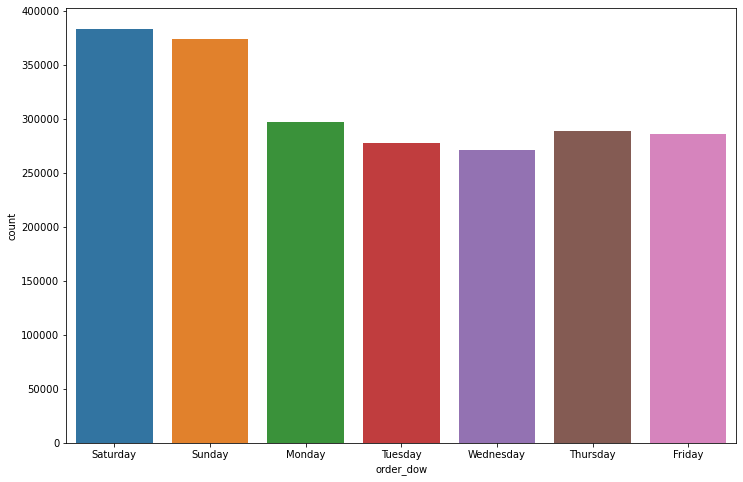

In [81]:
plt.figure(figsize=(12,8))
sns.countplot(orders_df['order_dow'])
plt.xticks(np.arange(7), ('Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday'))
plt.show()

In [82]:
orders_df['order_hour_of_day'].value_counts()

10    183465
11    181129
15    180622
14    179637
13    176833
12    173706
16    173550
9     164043
17    146054
18    116919
8     113225
19     90086
20     66317
7      58648
21     49991
22     38885
23     25388
6      19412
0      14586
1       7869
5       6203
2       4911
3       3568
4       3539
Name: order_hour_of_day, dtype: int64

# Observation :
    From above we observed that at 10 and 11 are the top two hour_of_day maximum orders placed.
    We thus infer that the maximum orders are placed when the "order_hour_of_day" is 10:00 hours.

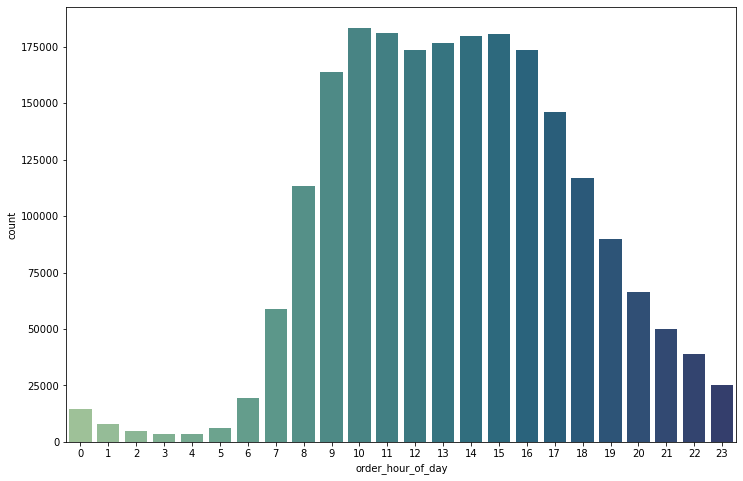

In [83]:
plt.figure(figsize=(12,8))
sns.countplot(orders_df['order_hour_of_day'],palette='crest')
plt.show()

In [84]:
Week_Hour = pd.pivot_table(data=orders_df,index=['order_hour_of_day'],columns=['order_dow'],values='order_id',aggfunc='count')

In [85]:
Week_Hour

order_dow,0,1,2,3,4,5,6
order_hour_of_day,,,,,,,
0,2552,2303,1933,1857,1725,2059,2157
1,1564,1128,993,958,979,1059,1188
2,951,732,604,608,595,665,756
3,661,474,449,422,432,546,584
4,521,517,474,459,448,610,510
5,773,1038,918,900,833,1016,725
6,2072,3446,2993,2879,2799,3147,2076
7,7969,10634,8509,7784,7957,8650,7145
8,17914,21522,15603,14477,13862,15305,14542


<AxesSubplot:xlabel='order_hour_of_day', ylabel='No.of Orders'>

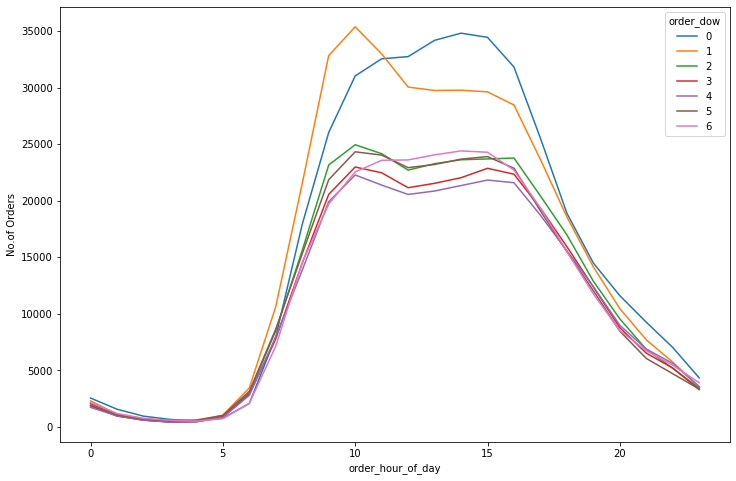

In [86]:
Week_Hour.plot(kind='line', ylabel='No.of Orders',figsize=(12,8))

In [87]:
for i in orders_df['order_dow'].unique():
    print("Weekday : " + str(i))
    print(orders_df['order_hour_of_day'][orders_df['order_dow']==i].value_counts()[0:1])

Weekday : 2
10    24947
Name: order_hour_of_day, dtype: int64
Weekday : 3
10    22977
Name: order_hour_of_day, dtype: int64
Weekday : 4
10    22273
Name: order_hour_of_day, dtype: int64
Weekday : 1
10    35375
Name: order_hour_of_day, dtype: int64
Weekday : 5
10    24321
Name: order_hour_of_day, dtype: int64
Weekday : 0
14    34810
Name: order_hour_of_day, dtype: int64
Weekday : 6
14    24400
Name: order_hour_of_day, dtype: int64


# Observation :
From above we observed that Maximum Orders are placed in Weekday : 1 and hour of day is 10. Total Orders placed : 35,375

We thus infer that the maximum orders are placed when the "day of week" is 1 i.e Sunday and the hour of day is 10:00

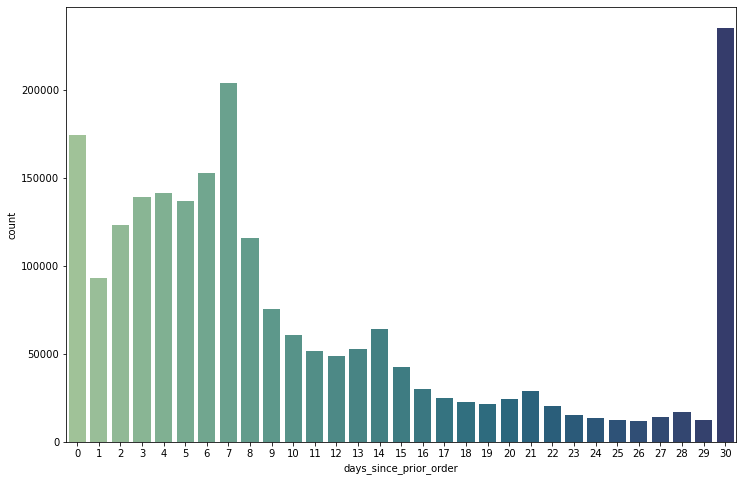

30    235153
7     203601
0     174140
6     152714
4     141084
3     138840
5     136949
2     123320
8     115677
1      92953
9      75464
14     63857
10     60681
13     52970
11     51401
12     48500
15     42249
16     29822
21     28849
17     24913
20     24458
18     22774
19     21727
22     20369
28     17072
23     15248
27     13914
24     13304
29     12269
25     12169
26     12145
Name: days_since_prior_order, dtype: int64


In [88]:
# Counting the Total Orders in the days_since_prior_order
cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
plt.rcParams["figure.figsize"] = (12,8)
sns.countplot(x='days_since_prior_order', data=orders_df, palette='crest')
plt.show()

print(orders_df['days_since_prior_order'].value_counts())

##### Observation
    We observe that customers mostly placed the orders in 30 days once

# Question 2:
    2) What are the top 5 products?

    -    That are ordered.
    -    That are reordered.

In [89]:
cmb_df = pd.concat([prior_df,train_df,test_df],keys=['prior','train','test'])

In [90]:
cmb_df.shape

(33819106, 4)

In [91]:
cmb_df.head()

order_id  product_id  add_to_cart_order  reordered
prior 0         2       33120                  1          1
      1         2       28985                  2          1
      2         2        9327                  3          0
      3         2       45918                  4          1
      4         2       30035                  5          0

In [92]:
cmb_df.tail()

order_id  product_id  add_to_cart_order  reordered
test 316444   3421058       32650                  8          1
     316445   3421063       49235                  1          1
     316446   3421063       13565                  2          1
     316447   3421063       14233                  3          1
     316448   3421063       35548                  4          1

In [93]:
cmb_df['product_id'].value_counts().head()

24852    491291
13176    394930
21137    275577
21903    251705
47209    220877
Name: product_id, dtype: int64

In [94]:
cmb_df =pd.merge(cmb_df,products_df,on='product_id')

In [95]:
cmb_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [96]:
cmb_df.shape

(33819106, 7)

#### Most Popular Products

In [97]:
temp_df = cmb_df.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

In [98]:
temp_df

,product_name,total,reorders
0,Banana,491291,415166
1,Bag of Organic Bananas,394930,329275
2,Organic Strawberries,275577,214448
3,Organic Baby Spinach,251705,194939
4,Organic Hass Avocado,220877,176173
...,...,...,...
49680,Greek Blended Cherry Fat Free Yogurt,1,0
49681,All Natural Stevia Liquid Extract Sweetener,1,0
49682,"Frittata, Farmer's Market",1,0
49683,Max White With Polishing Star Soft Toothbrush,1,0


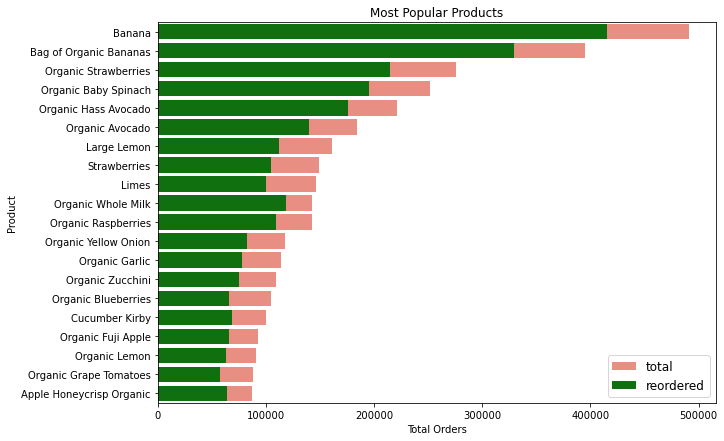

In [99]:
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.total[0:20], color='salmon', label = "total")
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.reorders[0:20],color='green',label = "reordered")
ax.set_ylabel("Product")
ax.set_xlabel("Total Orders")
ax.set_title("Most Popular Products")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

In [100]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df.sort_values("reorder_ratio", ascending=False).head(10)

,product_name,total,reorders,reorder_ratio
23853,Raw Veggie Wrappers,69,65,0.942029
21388,Serenity Ultimate Extrema Overnight Pads,90,84,0.933333
40147,Orange Energy Shots,13,12,0.923077
20296,Chocolate Love Bar,102,94,0.921569
30746,Soy Powder Infant Formula,35,32,0.914286
28078,Simply Sleep Nighttime Sleep Aid,45,41,0.911111
35213,"Energy Shot, Grape Flavor",22,20,0.909091
32316,Russian River Valley Reserve Pinot Noir,30,27,0.900000
23918,Bars Peanut Butter,69,62,0.898551
24218,Soy Crisps Lightly Salted,67,60,0.895522


#### Product wise No.of users

In [101]:
cmb_user_df = pd.merge(cmb_df,orders_df,on='order_id')

In [102]:
product_unique_users = cmb_user_df.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'total_users'})
product_unique_users.sort_values('total_users', ascending = False).head(10)

,product_name,total_users
3669,Banana,49133
3465,Bag of Organic Bananas,42611
31824,Organic Strawberries,39759
28755,Organic Baby Spinach,36826
22349,Large Lemon,31722
23354,Limes,30421
42771,Strawberries,29180
30208,Organic Hass Avocado,29007
28719,Organic Avocado,28468
28922,Organic Blueberries,25306


In [185]:
product_unique_users_1 = product_unique_users.sort_values('total_users', ascending = False).head(10)

In [186]:
product_unique_users_1

,product_name,total_users
3669,Banana,49133
3465,Bag of Organic Bananas,42611
31824,Organic Strawberries,39759
28755,Organic Baby Spinach,36826
22349,Large Lemon,31722
23354,Limes,30421
42771,Strawberries,29180
30208,Organic Hass Avocado,29007
28719,Organic Avocado,28468
28922,Organic Blueberries,25306


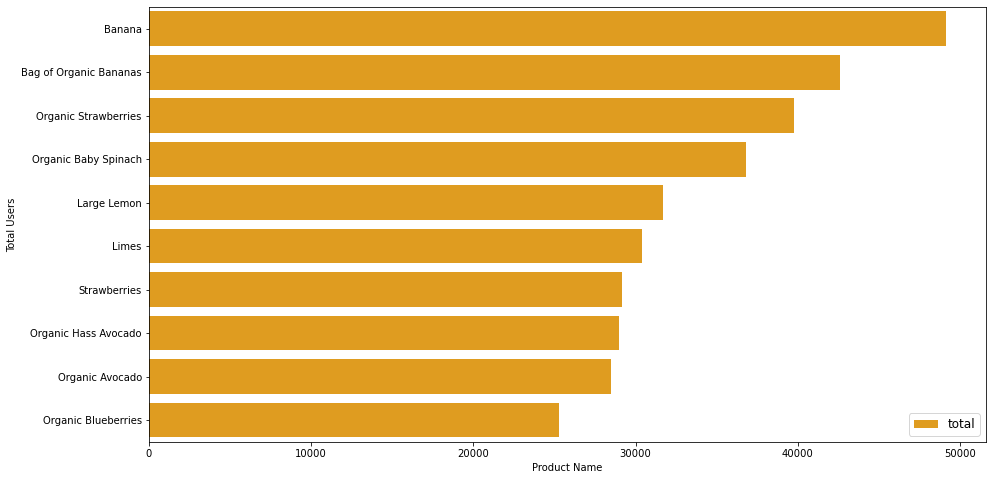

In [187]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = product_unique_users_1.product_name, x = product_unique_users_1["total_users"],color = 'orange',label = "total")
ax.set_ylabel("Total Users")
ax.set_xlabel("Product Name")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

#### Cumulative Sum of Unique Users Per Product

In [104]:
temp_df = product_unique_users.sort_values("total_users", ascending=False)
temp_df['cum_users'] = temp_df['total_users'].cumsum()
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,product_name,total_users,cum_users
0,Banana,49133,49133
1,Bag of Organic Bananas,42611,91744
2,Organic Strawberries,39759,131503
3,Organic Baby Spinach,36826,168329
4,Large Lemon,31722,200051


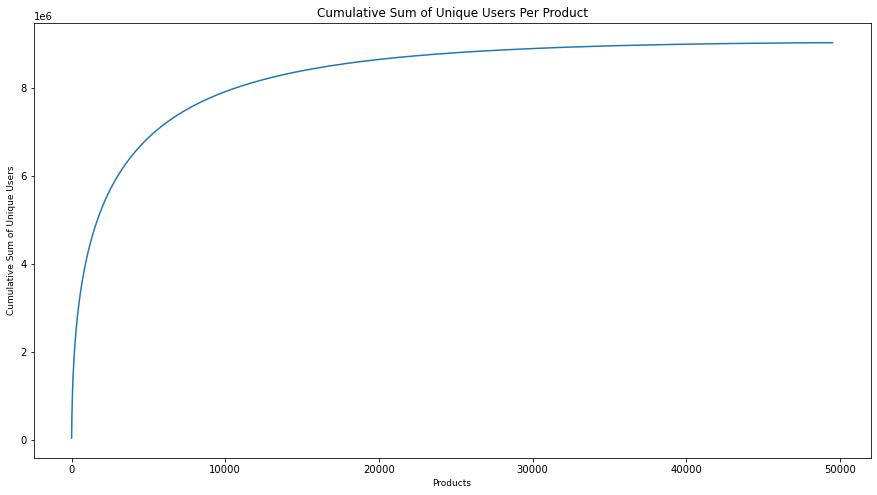

In [105]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.lineplot(x = temp_df.index, y=temp_df.cum_users)
ax.set_xlabel("Products", size = 9)
ax.set_ylabel("Cumulative Sum of Unique Users", size = 9)
ax.set_title("Cumulative Sum of Unique Users Per Product", size = 12)
plt.show()

##### Most Popular Products on different days

In [106]:
temp_df = cmb_user_df.groupby(['order_dow', 'product_name']).size().reset_index(name='counts')
temp_df = temp_df.sort_values(['order_dow', 'counts'], ascending=[True, False])
temp_df = temp_df.groupby('order_dow').head(5).reset_index(drop = True)

Text(0.5, 0.98, 'Most Popular Products on different Days of Week')

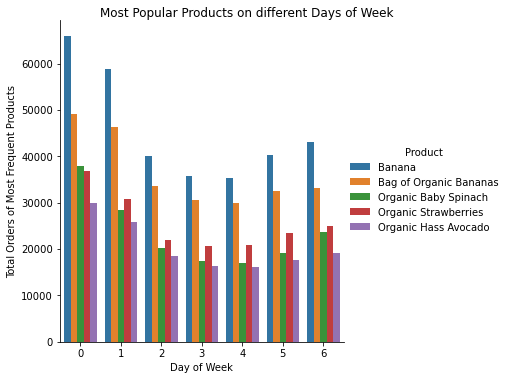

In [107]:
ax = sns.catplot(x="order_dow", y="counts", hue="product_name", data=temp_df, kind="bar", legend=False, height=5)
ax.add_legend(title="Product")
ax.set_axis_labels("Day of Week", "Total Orders of Most Frequent Products")
ax.fig.suptitle("Most Popular Products on different Days of Week", va="baseline", ha="center")

In [108]:
top5_product_ordered = pd.concat([pd.DataFrame(dict(cmb_df['product_id'].value_counts().head()).keys(),
                                       columns=['product_id']),
                          pd.DataFrame(dict(cmb_df['product_id'].value_counts().head()).values(),
                                       columns=['order_count'])],axis=1)

In [109]:
top5_product_ordered =pd.merge(top5_product_ordered,products_df,on='product_id')

In [110]:
top5_product_ordered.head()

,product_id,order_count,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4


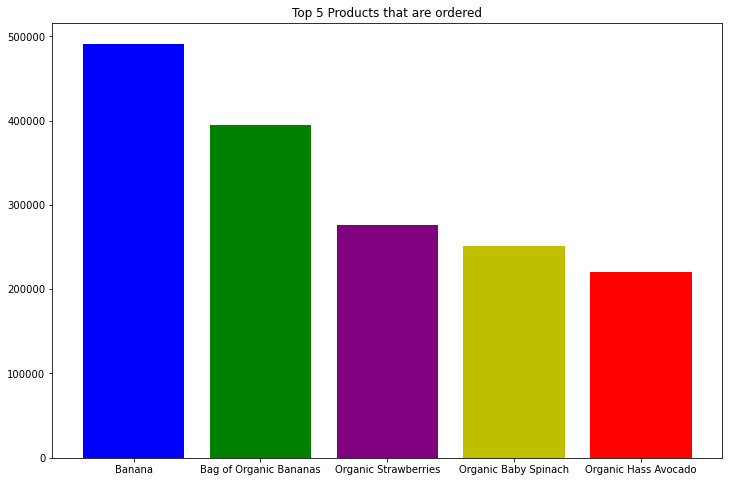

In [111]:
plt.figure(figsize=(12,8))
plt.title("Top 5 Products that are ordered")
plt.bar(top5_product_ordered['product_name'],top5_product_ordered['order_count'],color=['b','g','purple','y','r'])
plt.xticks(rotation=0);plt.show()

In [112]:
#top 5 products that are reordered
cmb_df['product_id'][cmb_df['reordered']==1].value_counts().head()

24852    415166
13176    329275
21137    214448
21903    194939
47209    176173
Name: product_id, dtype: int64

In [113]:
top5_product_reordered = pd.concat([pd.DataFrame(dict(cmb_df['product_id'][cmb_df[
    'reordered']==1].value_counts().head()).keys(), columns=['product_id']),
                                    pd.DataFrame(dict(cmb_df['product_id'][cmb_df[
                                        'reordered']==1].value_counts().head()).values(), columns=['order_count'])],axis=1)

In [114]:
top5_product_reordered =pd.merge(top5_product_reordered,products_df,on='product_id')

In [115]:
top5_product_reordered.head()

,product_id,order_count,product_name,aisle_id,department_id
0,24852,415166,Banana,24,4
1,13176,329275,Bag of Organic Bananas,24,4
2,21137,214448,Organic Strawberries,24,4
3,21903,194939,Organic Baby Spinach,123,4
4,47209,176173,Organic Hass Avocado,24,4


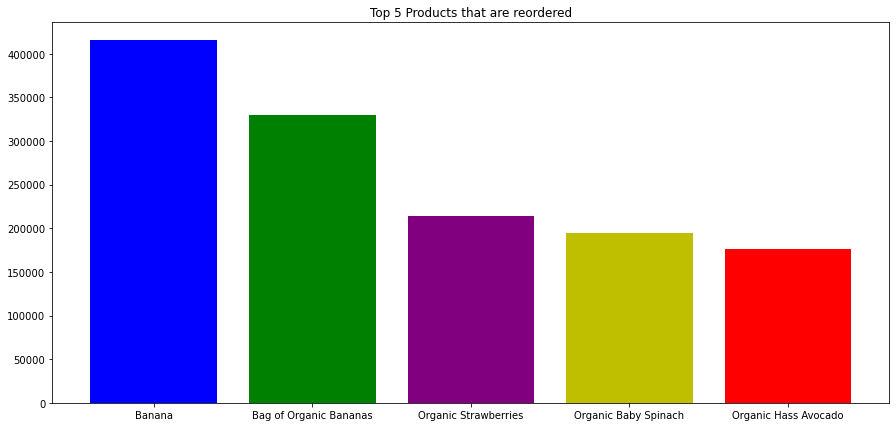

In [116]:
plt.figure(figsize=(15,7))
plt.title("Top 5 Products that are reordered")
plt.bar(top5_product_reordered['product_name'],top5_product_reordered['order_count'],color=['b','g','purple','y','r'])
plt.xticks(rotation=0);plt.show()

In [117]:
top5_product_ordered

,product_id,order_count,product_name,aisle_id,department_id
0,24852,491291,Banana,24,4
1,13176,394930,Bag of Organic Bananas,24,4
2,21137,275577,Organic Strawberries,24,4
3,21903,251705,Organic Baby Spinach,123,4
4,47209,220877,Organic Hass Avocado,24,4


# Question 3
    3)	What is the reorder ratio for each department?

In [118]:
cmb_dept_df = pd.merge(pd.merge(cmb_df,orders_df,on='order_id'),
                                         pd.merge(products_df,departments_df,on='department_id'),on='product_id')

In [119]:
cmb_dept_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name_x,aisle_id_x,department_id_x,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,user_id,product_name_y,aisle_id_y,department_id_y,department
0,2,33120,1,1,Organic Egg Whites,86,16,8,prior,5,9,3,202279,Organic Egg Whites,86,16,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,7,prior,0,16,2,153404,Organic Egg Whites,86,16,dairy eggs
2,327,33120,5,1,Organic Egg Whites,86,16,8,prior,6,9,21,58707,Organic Egg Whites,86,16,dairy eggs
3,537,33120,2,1,Organic Egg Whites,86,16,3,prior,2,8,15,180135,Organic Egg Whites,86,16,dairy eggs
4,582,33120,7,1,Organic Egg Whites,86,16,10,prior,2,19,6,193223,Organic Egg Whites,86,16,dairy eggs


In [120]:
temp_df = cmb_dept_df.groupby("department")["reordered"].agg(['count', 'sum']).rename(
    columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

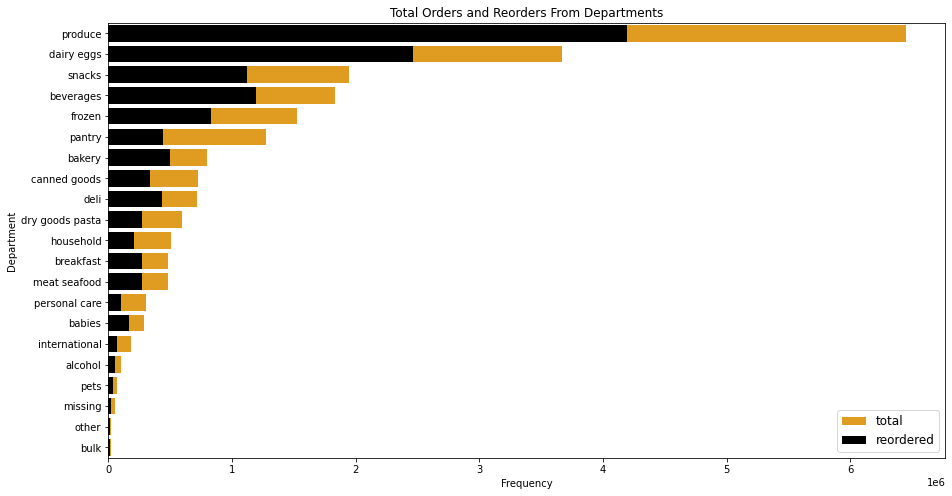

In [121]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.department, x = temp_df["total"],color = 'orange',label = "total")
ax = sns.barplot(y = temp_df.department, x = temp_df["reorders"],color = 'black', label = "reordered")
ax.set_ylabel("Department")
ax.set_xlabel("Frequency")
ax.legend(loc = 4, prop={'size': 12})
ax.set_title("Total Orders and Reorders From Departments")
plt.show()

In [122]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df = temp_df.sort_values("reorder_ratio", ascending=False).reset_index()

In [123]:
temp_df.head()

,index,department,total,reorders,reorder_ratio
0,1,dairy eggs,3668700,2459739,0.670466
1,3,beverages,1828653,1196597,0.654360
2,0,produce,6447546,4194600,0.650573
3,6,bakery,795949,499504,0.627558
4,8,deli,713827,434253,0.608345


#### Departments with Highest Reorder Ratio

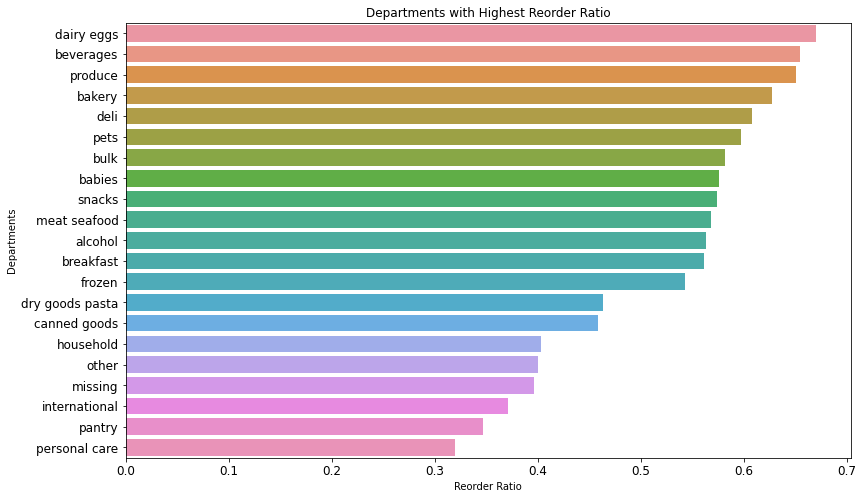

In [124]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = temp_df.department, x = temp_df.reorder_ratio)
ax.set_ylabel("Departments")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Departments with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

# Computation of Department Ratio
1. Re order ratio for each deparment product wise - Reorderd product(department)/Total products(department)
2. Mximum reorder ratio - All Rerdered products/ Total Products - of which deaprment 

In [125]:
grp_user_order_df=cmb_dept_df.groupby(['user_id','order_id'])['eval_set'].aggregate('count').reset_index()

In [126]:
grp_user_order_df['user_id'].value_counts()

186507    100
154160    100
43352     100
116331    100
145555    100
         ... 
155814      4
181707      4
33409       4
198795      4
160348      4
Name: user_id, Length: 131209, dtype: int64

In [127]:
grp_user_order_df

,user_id,order_id,eval_set
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,1187899,11
4,1,2254736,5
...,...,...,...
2178581,206209,2307371,3
2178582,206209,2558525,3
2178583,206209,2977660,9
2178584,206209,3154581,13


In [128]:
grp_user_order_count=pd.concat([pd.DataFrame(dict(grp_user_order_df['user_id'].value_counts()).keys(),
                                 columns=['user_id']),
                    pd.DataFrame(dict(grp_user_order_df['user_id'].value_counts()).values(),
                                 columns=['order_count'])],axis=1)

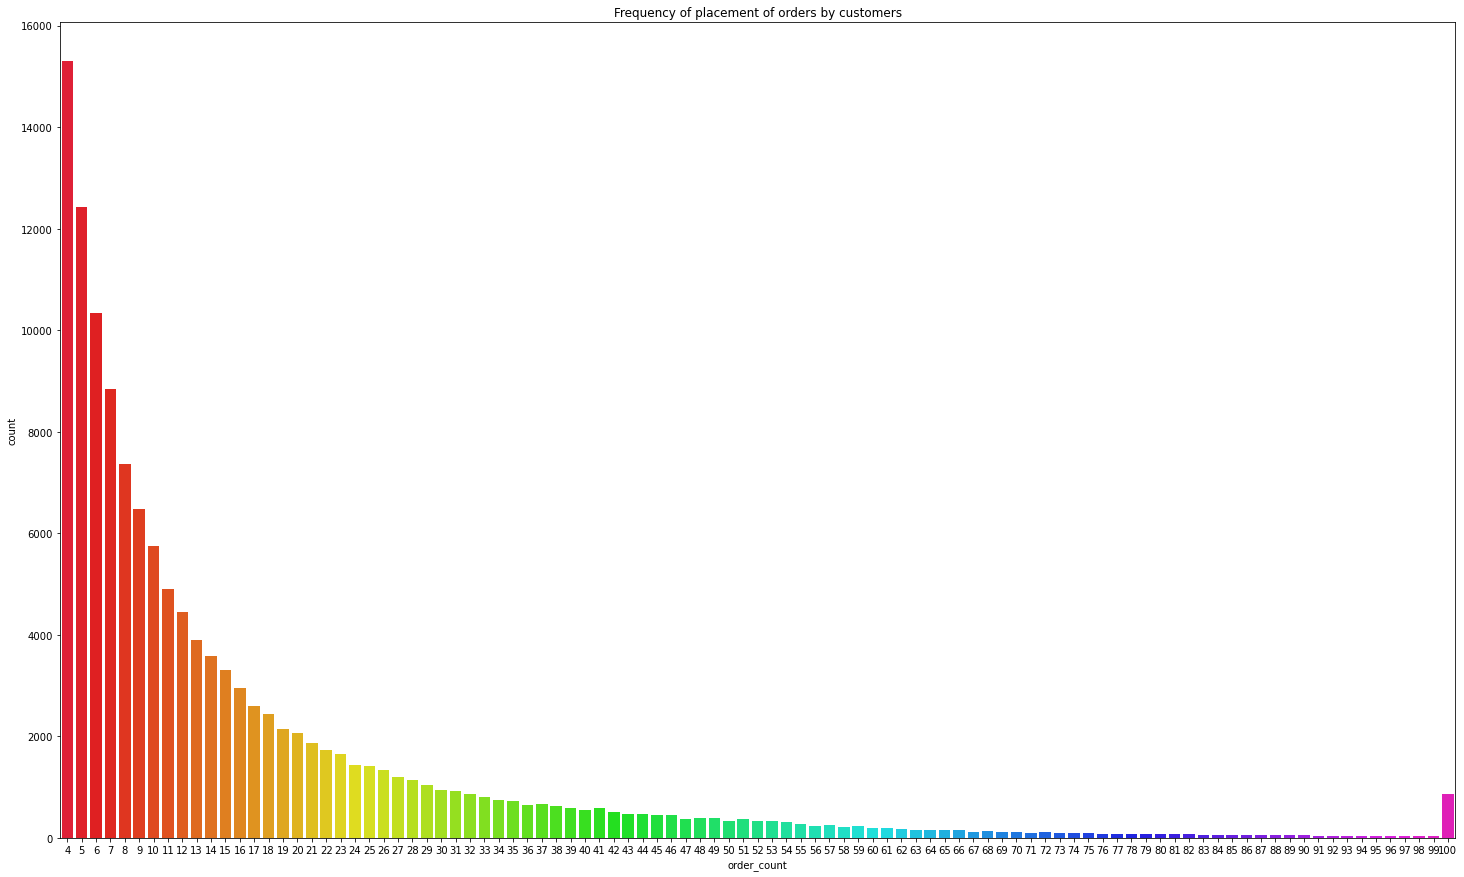

In [129]:
plt.figure(figsize=(25,15))
plt.title("Frequency of placement of orders by customers")
sns.countplot(grp_user_order_count['order_count'],palette='gist_rainbow')
# plt.yticks(np.arange(0,16000,500))
plt.show()

In [130]:
grp_user_order_count['order_count'].value_counts()

4     15300
5     12439
6     10337
7      8853
8      7357
      ...  
95       39
93       33
98       31
99       31
97       30
Name: order_count, Length: 97, dtype: int64

In [131]:
cmb_dept_df.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name_x', 'aisle_id_x', 'department_id_x',
       'days_since_prior_order', 'eval_set', 'order_dow', 'order_hour_of_day',
       'order_number', 'user_id', 'product_name_y', 'aisle_id_y',
       'department_id_y', 'department'],
      dtype='object')

In [132]:
grp_user_days_since_prior_order = cmb_dept_df.groupby(
    ['days_since_prior_order','user_id','order_id'])['eval_set'].aggregate('count').reset_index()

In [133]:
grp_user_days_since_prior_order['days_since_prior_order'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
      dtype=int64)

In [134]:
grp_user_days_since_prior_order['days_since_prior_order'].value_counts()

30    235153
7     203601
0     174140
6     152714
4     141084
3     138840
5     136949
2     123320
8     115677
1      92953
9      75464
14     63857
10     60681
13     52970
11     51401
12     48500
15     42249
16     29822
21     28849
17     24913
20     24458
18     22774
19     21727
22     20369
28     17072
23     15248
27     13914
24     13304
29     12269
25     12169
26     12145
Name: days_since_prior_order, dtype: int64

In [135]:
grp_user_dspo_count=pd.concat([pd.DataFrame(dict(grp_user_days_since_prior_order['days_since_prior_order'].value_counts()
                                                ).keys(), columns=['Number of Days']),
                    pd.DataFrame(dict(grp_user_days_since_prior_order['days_since_prior_order'].value_counts()).values(),
                                 columns=['order_count'])],axis=1)

In [136]:
orders_df['days_since_prior_order'].value_counts()

30    235153
7     203601
0     174140
6     152714
4     141084
3     138840
5     136949
2     123320
8     115677
1      92953
9      75464
14     63857
10     60681
13     52970
11     51401
12     48500
15     42249
16     29822
21     28849
17     24913
20     24458
18     22774
19     21727
22     20369
28     17072
23     15248
27     13914
24     13304
29     12269
25     12169
26     12145
Name: days_since_prior_order, dtype: int64

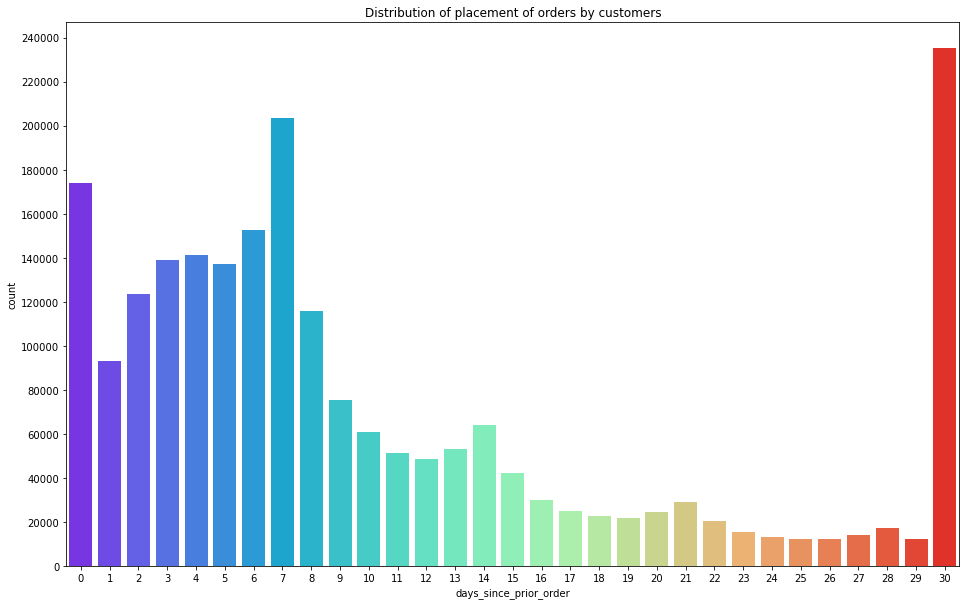

In [137]:
plt.figure(figsize=(16,10))
plt.title("Distribution of placement of orders by customers")
sns.countplot(orders_df['days_since_prior_order'],palette='rainbow')

# plt.bar(grp_user_dspo_count['Number of Days'],
#         grp_user_dspo_count['order_count'])
plt.yticks(np.arange(0,250000,20000))
# plt.xticks(np.arange(0,31,1))
plt.show()

# 4. Data Preprocessing for Model Building

In [138]:
# train dataset
x_tr = pd.merge(train_df,orders_df,on='order_id')

In [139]:
x_tr.shape

(1068168, 10)

In [140]:
x_tr.head()

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,user_id
0,36,39612,1,0,30,train,6,18,23,79431
1,36,19660,2,1,30,train,6,18,23,79431
2,36,49235,3,0,30,train,6,18,23,79431
3,36,43086,4,1,30,train,6,18,23,79431
4,36,46620,5,1,30,train,6,18,23,79431


In [141]:
x_train=x_tr.drop(columns=['order_id','reordered','eval_set','user_id'])

In [142]:
x_train.head()

,product_id,add_to_cart_order,days_since_prior_order,order_dow,order_hour_of_day,order_number
0,39612,1,30,6,18,23
1,19660,2,30,6,18,23
2,49235,3,30,6,18,23
3,43086,4,30,6,18,23
4,46620,5,30,6,18,23


In [143]:
y_train = x_tr['reordered']

In [144]:
y_train.shape

(1068168,)

In [145]:
y_train.value_counts()

1    639426
0    428742
Name: reordered, dtype: int64

In [146]:
# test dataset
x_te = pd.merge(test_df,orders_df,on='order_id')

In [147]:
x_te.shape

(316449, 10)

In [148]:
x_te.head()

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order,eval_set,order_dow,order_hour_of_day,order_number,user_id
0,1,49302,1,1,9,test,4,10,4,112108
1,1,11109,2,1,9,test,4,10,4,112108
2,1,10246,3,0,9,test,4,10,4,112108
3,1,49683,4,0,9,test,4,10,4,112108
4,1,43633,5,1,9,test,4,10,4,112108


In [149]:
x_test=x_te.drop(columns=['order_id','reordered','eval_set','user_id'])

In [150]:
x_test.head()

,product_id,add_to_cart_order,days_since_prior_order,order_dow,order_hour_of_day,order_number
0,49302,1,9,4,10,4
1,11109,2,9,4,10,4
2,10246,3,9,4,10,4
3,49683,4,9,4,10,4
4,43633,5,9,4,10,4


In [151]:
y_test = x_te['reordered']

In [152]:
y_test.shape

(316449,)

In [153]:
y_test.value_counts()

1    189398
0    127051
Name: reordered, dtype: int64

# 5. Model Building
    
    5.1 Build Logistic Regression
    5.2 Naive_bayes
    5.3 Build Decision Tree
    5.4 Build Random Forest
    5.5 AdaBoost
    5.6 Gradient Boosting

### 5.1 Logistic Regression

In [154]:
lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [155]:
# fit the model to the training data
lr.fit(x_train,y_train)

LogisticRegression(random_state=0)

In [156]:
# making predictions using the model
y_pred_lr = lr.predict(x_test)
y_pred_lr

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [157]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_df = confusion_matrix(y_test, y_pred_lr)
print(confusion_matrix_df)

[[ 45800  81251]
 [ 29865 159533]]


In [158]:
# generate model performance metrics

accuracy_lr = accuracy_score(y_test,y_pred_lr)
f1_lr=f1_score(y_test,y_pred_lr)
precision_lr = precision_score(y_test,y_pred_lr)
recall_lr = recall_score(y_test,y_pred_lr)
roc_auc_lr = roc_auc_score(y_test,y_pred_lr)

print('Accuracy is :', accuracy_lr)
print('F1 Score is :', f1_lr)
print('Precision is :',precision_lr)
print('Recall is :',recall_lr)
print('Area under the curve is :', roc_auc_lr)

Accuracy is : 0.6488660100047717
F1 Score is : 0.7417000246407335
Precision is : 0.6625564821582829
Recall is : 0.8423161807410849
Area under the curve is : 0.601400670121981


# Conclusion for Logistic regression
We obtain a good F1 score of 74.17%
However, we can further try to improve the obtained accuracy which is 64.89%
The recall obtained is good i.e. 84.23% but the precision can be improved which is 66.25%

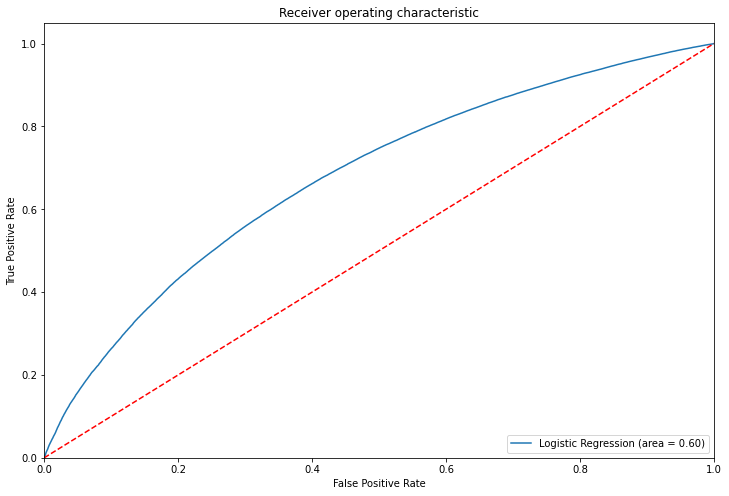

In [159]:
# ROC curve

logit_roc_auc = roc_auc_score(y_test, y_pred_lr)
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### 5.2 Naive_bayes

In [160]:
from sklearn.naive_bayes import GaussianNB
nvby = GaussianNB()
nvby.fit(x_train,y_train)
y_pred_nvby=nvby.predict(x_test)

In [161]:
accuracy_nvby = accuracy_score(y_test,y_pred_nvby)
f1_nvby=f1_score(y_test,y_pred_nvby)
precision_nvby = precision_score(y_test,y_pred_nvby)
recall_nvby = recall_score(y_test,y_pred_nvby)
roc_auc_nvby = roc_auc_score(y_test,y_pred_nvby)

print('Accuracy is :', accuracy_nvby)
print('F1 Score is :', f1_nvby)
print('Precision is :',precision_nvby)
print('Recall is :',recall_nvby)
print('Area under the curve is :', roc_auc_nvby)

Accuracy is : 0.6161182370618963
F1 Score is : 0.6705716772834143
Precision is : 0.6893381430538752
Recall is : 0.65279992396963
Area under the curve is : 0.6071179413789166


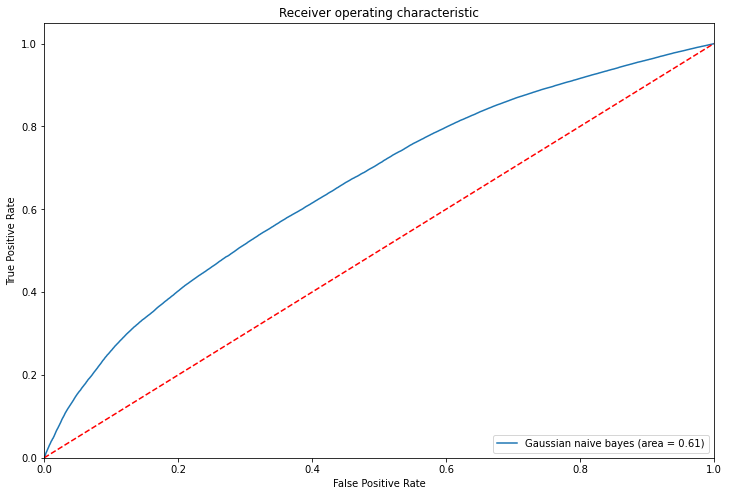

In [162]:
# ROC curve

logit_roc_auc = roc_auc_score(y_test, y_pred_nvby)
fpr, tpr, thresholds = roc_curve(y_test, nvby.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gaussian naive bayes (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Conclusion for Gaussian naive bayes
    Algorithm             Accuracy	F1	Precision	Recalll	 AUC
    Logistic Regression   65%	    74%	66%	        86%	    60%
    Gaussian Naïve Bayes  62%	    67%	69%	        65%	    61%

    The Precision improved, but there is reduction in Accuracy, F1 and Recall

### 5.3 Decision Tree

In [163]:
dt = tree.DecisionTreeClassifier()

In [164]:
#train the model using traing data
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [165]:

y_pred_dt=dt.predict(x_test)
y_pred_dt

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

In [166]:
accuracy_dt = accuracy_score(y_test,y_pred_dt)
f1_dt=f1_score(y_test,y_pred_dt)
precision_dt = precision_score(y_test,y_pred_dt)
recall_dt = recall_score(y_test,y_pred_dt)
roc_auc_dt = roc_auc_score(y_test,y_pred_dt)

print('Accuracy is :', accuracy_dt)
print('F1 Score is :', f1_dt)
print('Precision is :',precision_dt)
print('Recall is :',recall_dt)
print('Area under the curve is :', roc_auc_dt)


Accuracy is : 0.5718709807899535
F1 Score is : 0.6388974031616234
Precision is : 0.6451027778824365
Recall is : 0.6328102725477566
Area under the curve is : 0.5569187882718948


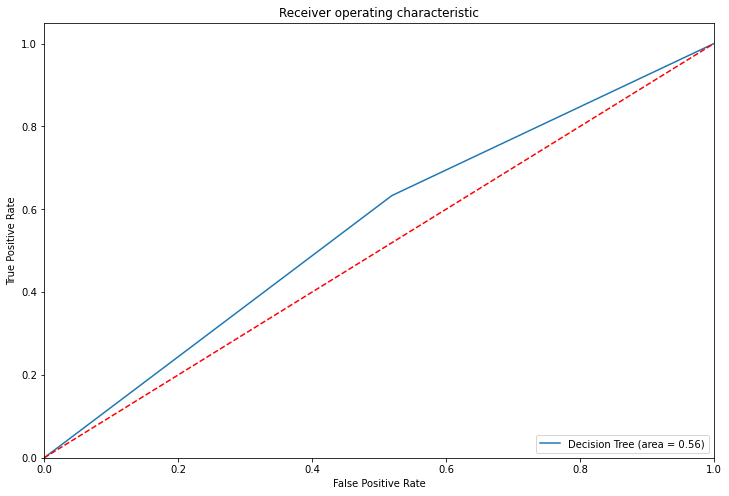

In [167]:
# ROC curve

logit_roc_auc = roc_auc_score(y_test, y_pred_dt)
fpr, tpr, thresholds = roc_curve(y_test, dt.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Conclusion for Decision Trees
    Algorithm             Accuracy	F1	Precision	Recalll	    AUC
    Logistic Regression   65%	    74%	  66%	        86%	    60%
    Gaussian Naïve Bayes  62%	    67%	  69%	        65%	    61%
    Decision Trees        57%        64%      65%            63%        56%

    Again, no improvement in Accuracy, F1 and recall. AUC has reduced further. Precision is lesser than Gaussian.

### 5.4 Random Forest

In [168]:
# Build a classifier
rf = RandomForestClassifier(n_estimators=100)

In [169]:
#train the model using trainig data
rf.fit(x_train, y_train)

RandomForestClassifier()

In [170]:
y_pred_rf=rf.predict(x_test)
y_pred_rf

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [171]:
accuracy_rf = accuracy_score(y_test,y_pred_rf)
f1_rf=f1_score(y_test,y_pred_rf)
precision_rf = precision_score(y_test,y_pred_rf)
recall_rf = recall_score(y_test,y_pred_rf)
roc_auc_rf = roc_auc_score(y_test,y_pred_rf)

print('Accuracy is :', accuracy_rf)
print('F1 Score is :', f1_rf)
print('Precision is :',precision_rf)
print('Recall is :',recall_rf)
print('Area under the curve is :', roc_auc_rf)

Accuracy is : 0.6309515909356642
F1 Score is : 0.7092767080320136
Precision is : 0.6710094344510543
Recall is : 0.752172673417882
Area under the curve is : 0.6012085317329865


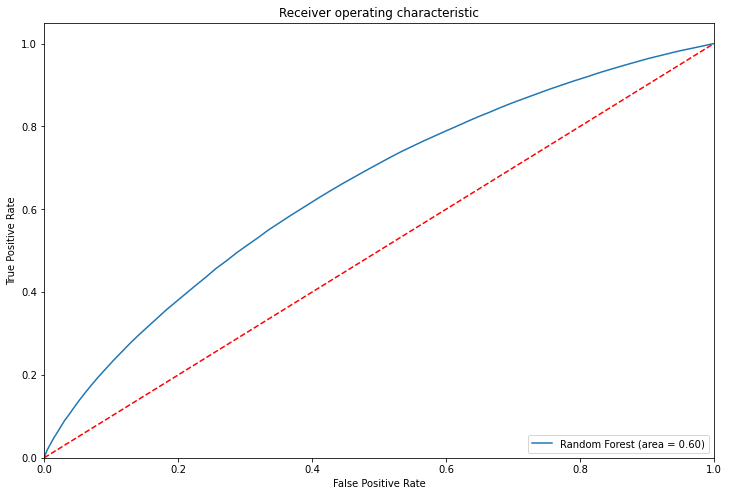

In [172]:
# ROC curve

logit_roc_auc = roc_auc_score(y_test, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

  # Conclusion for Random Forest
    
    Algorithm             Accuracy	F1	Precision	Recalll	    AUC
    Logistic Regression   65%	    74%	  66%	        86%	    60%
    Gaussian Naïve Bayes  62%	    67%	  69%	        65%	    61%
    Decision Trees        57%        64%      65%            63%        56%
    Random Forest         63%        71%      67%            75%        60%
    
    Some paramaters are  still less as compared to Logistic

### 5.5 AdaBoost

In [173]:
adaBoostClf= AdaBoostClassifier(n_estimators=100)

In [174]:
adaBoostClf.fit(x_test,y_test)

AdaBoostClassifier(n_estimators=100)

In [175]:
y_pred_adb=adaBoostClf.predict(x_test)
y_pred_adb

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

In [176]:
accuracy_adb = accuracy_score(y_test,y_pred_adb)
f1_adb=f1_score(y_test,y_pred_adb)
precision_adb = precision_score(y_test,y_pred_adb)
recall_adb = recall_score(y_test,y_pred_adb)
roc_auc_adb = roc_auc_score(y_test,y_pred_adb)

print('Accuracy is :', accuracy_adb)
print('F1 Score is :', f1_adb)
print('Precision is :',precision_adb)
print('Recall is :',recall_adb)
print('Area under the curve is :', roc_auc_adb)


Accuracy is : 0.6613261536614115
F1 Score is : 0.7405194308389969
Precision is : 0.6838407913035313
Recall is : 0.8074425284321904
Area under the curve is : 0.6254747332954413


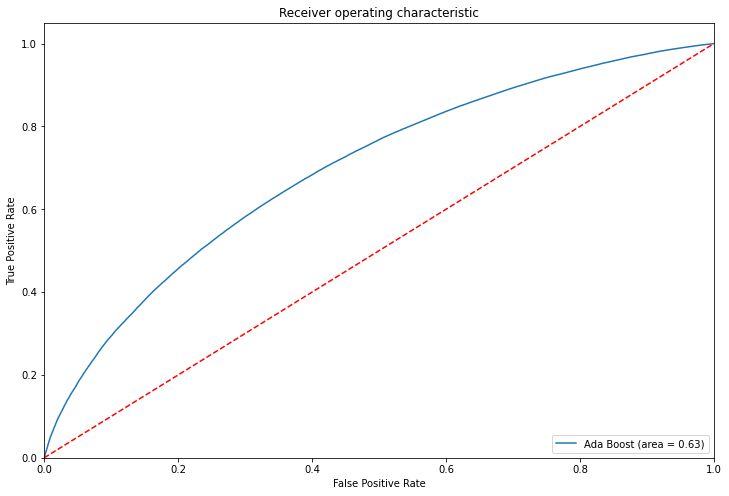

In [177]:
# ROC curve

logit_roc_auc = roc_auc_score(y_test, y_pred_adb)
fpr, tpr, thresholds = roc_curve(y_test, adaBoostClf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Ada Boost (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

  # Conclusion for Adaboost 
    
    Algorithm             Accuracy	F1	Precision	Recalll	    AUC
    Logistic Regression   65%	    74%	  66%	        86%	    60%
    Gaussian Naïve Bayes  62%	    67%	  69%	        65%	    61%
    Decision Trees        57%        64%      65%            63%        56%
    Random Forest         63%        71%      67%            75%        60%
    Adaboost              66%        74%      68%            81%        63%
    
    
    Recall is lesser than  Logistic, but Acc and F1 same and Precision has improved

### 5.6 Gradient Boosting

In [178]:
GrdBoostclf = GradientBoostingClassifier(n_estimators=100)

In [179]:
GrdBoostclf.fit(x_train, y_train)

GradientBoostingClassifier()

In [180]:
y_pred_grdb = GrdBoostclf.predict(x_test)

In [181]:
accuracy_grdb = accuracy_score(y_test,y_pred_grdb)
f1_grdb=f1_score(y_test,y_pred_grdb)
precision_grdb = precision_score(y_test,y_pred_grdb)
recall_grdb = recall_score(y_test,y_pred_grdb)
roc_auc_grdb = roc_auc_score(y_test,y_pred_grdb)

print('Accuracy is :', accuracy_grdb)
print('F1 Score is :', f1_grdb)
print('Precision is :',precision_grdb)
print('Recall is :',recall_grdb)
print('Area under the curve is :', roc_auc_grdb)

Accuracy is : 0.6632601145840246
F1 Score is : 0.7430463288715702
Precision is : 0.6838281308946301
Recall is : 0.8134932787041046
Area under the curve is : 0.6263985901434668


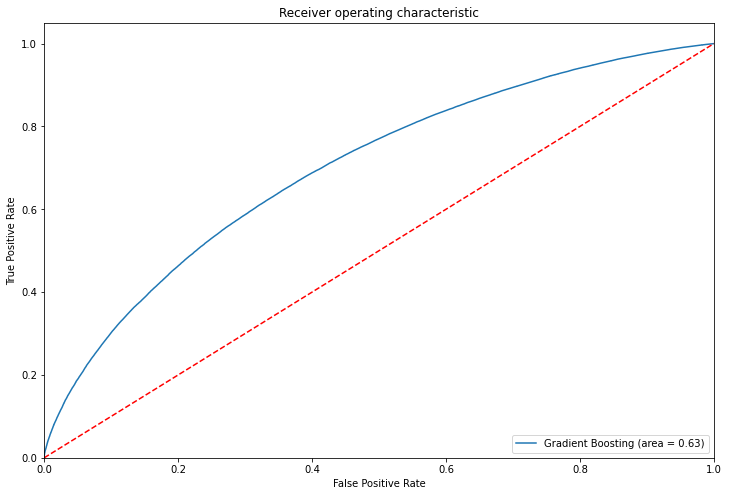

In [182]:
# ROC curve

logit_roc_auc = roc_auc_score(y_test, y_pred_grdb)
fpr, tpr, thresholds = roc_curve(y_test, GrdBoostclf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [183]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_df = confusion_matrix(y_test, y_pred_lr)
print(confusion_matrix_df)

[[ 45800  81251]
 [ 29865 159533]]


  # Conclusion for Gradient 
    
    Algorithm             Accuracy	F1	Precision	Recalll	    AUC
    Logistic Regression   65%	    74%	  66%	        86%	    60%
    Gaussian Naïve Bayes  62%	    67%	  69%	        65%	    61%
    Decision Trees        57%        64%      65%            63%        56%
    Random Forest         63%        71%      67%            75%        60%
    Adaboost              66%        74%      68%            81%        63%
    Gradient              66%        74%      68%            81%        63%
    Improvement in the Precision and Accuracy wrt Logistic